A lot of inspiration from these great notebooks:
1. [TPS Dec. 2021 "Covertype": Simple elevation model](https://www.kaggle.com/carlmcbrideellis/tps-dec-2021-covertype-simple-elevation-model/comments#1613693) by @carlmcbrideellis.
2. [Histograms for a good prediction](https://www.kaggle.com/thalesgaluchi/histograms-for-a-good-prediction) by @thalesgaluchi

Thanks a lot for sharing. I learned a great deal from your notebooks :)

In this month's TPS the dataset is quite imbalanced. Also there are very few features that shows good correlation with the target variable. Thus, some simple rules can be easily made on these features to classify the majority classes fairly accurately. In this notebook, we will see how we can come with up some of these rules.

# Part 1: Preprocessing

In [1]:
import numpy as np
import pandas as pd
from matplotlib import style
import matplotlib.pyplot as plt
%matplotlib inline


plt.style.use("seaborn")
pd.set_option("display.max_columns", None)

train_df = pd.read_csv("../input/tabular-playground-series-dec-2021/train.csv")
test_df = pd.read_csv("../input/tabular-playground-series-dec-2021/test.csv")
sub_df = pd.read_csv("../input/tabular-playground-series-dec-2021/sample_submission.csv")

Dropping **Id** column from both train and test datasets. Also dropping **Cover_Type=5** as there is only a single row corresponding to it.

In [2]:
train_df.drop("Id", axis=1, inplace=True)
test_df.drop("Id", axis=1, inplace=True)

idx = train_df[train_df["Cover_Type"] == 5].index
train_df.drop(idx, axis=0, inplace=True)

# Part 2: Feature Elimination

Since our goal is to select features that are highly correlated to the target variable, we will try to drop less important feature at each step.

Due to the low variance of categrical columns, we will consider only continuos columns.

In [3]:
cols = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

Since the features are continuous and target is categorical, we can use one-way ANOVA to perform further feature elimination.

<AxesSubplot:>

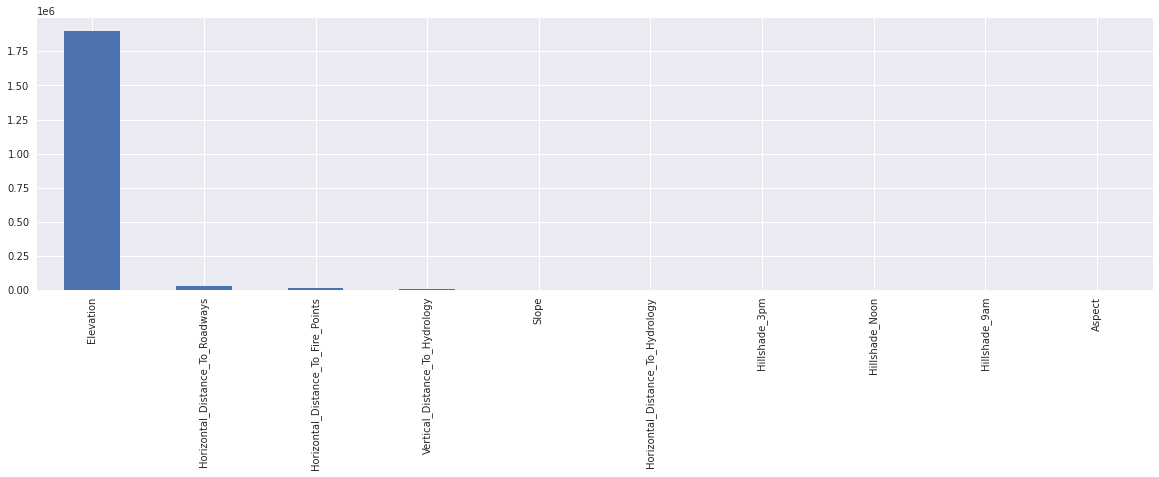

In [4]:
from sklearn.feature_selection import f_classif, SelectKBest


selector = SelectKBest(f_classif, k="all")
selector.fit(
    train_df[cols],
    train_df["Cover_Type"]
)

pd.Series(selector.scores_, index=cols).nlargest(len(cols)).plot(kind="bar", figsize=(20, 5))

Clearly, the **Elevation** feature shows far better correlation with **Cover_Type** compared to other features so we will perform modelling only with this feature.

# Part 3: White-box modelling

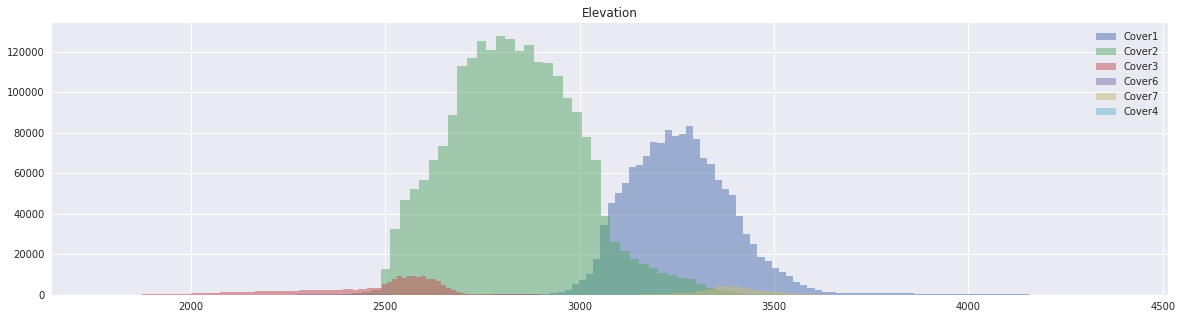

In [5]:
# This code is borrowed from -> https://www.kaggle.com/thalesgaluchi/histograms-for-a-good-prediction
fig, ax = plt.subplots(figsize=(20, 5))
for item in train_df["Cover_Type"].unique():
    ax.hist(train_df[train_df.Cover_Type.isin([item])]["Elevation"], alpha=0.5, label='Cover'+str(item), bins= 100)
    ax.set_title("Elevation")

ax.legend()

Clearly, the following **approximate** simple rules can seperate most of the samples:
1. Elevation < 2500 -> **Class 3: Ponderosa Pine**
2. 2500 <= Elevation < 3200 -> **Class 2: Lodgepole Pine**
3. Elevation >= 3200 -> **Class 1: Spruce/Fir**

However, the boundary values - 2500 and 3200 - are approximate and we may misclassify some samples. The boundary values for which the seperation is the maximum possible can be found by maximizing classification accuracy or by minimizing the misclassification cost. We can use a [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for this purpose for it makes decision rules of the sort we need in this case. Also, we would not want a decision tree to create complex decision boundaries as they may be hard to interpret. Setting **max_depth=2** in the classifier will ensure that we don't create decision boundaries more complex than the already discussed approximate rules.

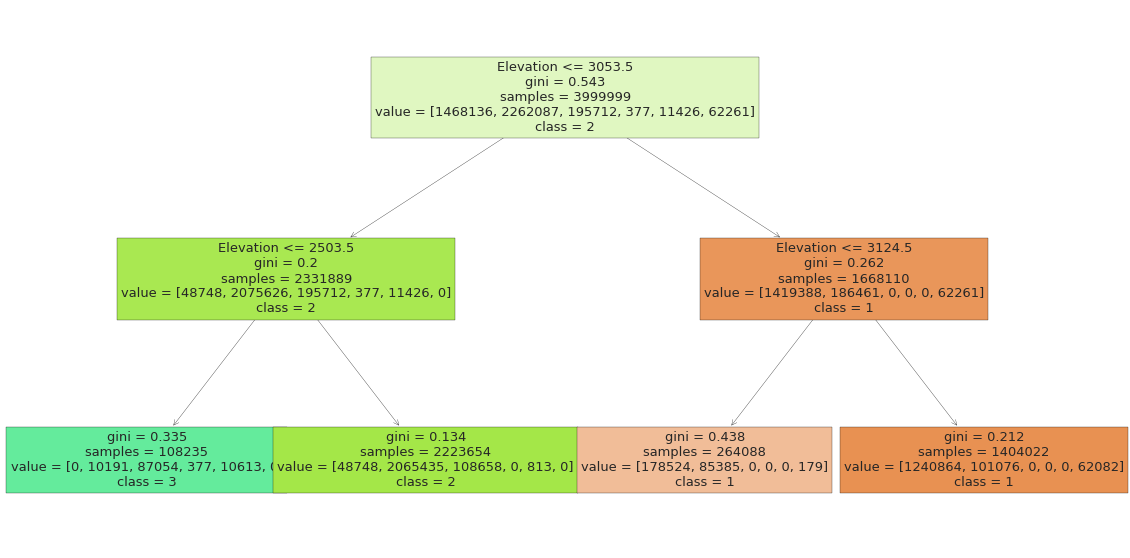

In [6]:
# Modelling using only elevation
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split


clf = DecisionTreeClassifier(max_depth=2)
clf.fit(
    train_df[["Elevation"]],
    train_df["Cover_Type"]
)

_, ax = plt.subplots(figsize=(20, 10))

plot_tree(
    clf,
    feature_names=["Elevation"],
    class_names=train_df["Cover_Type"].unique().astype(str),
    filled=True,
    ax=ax,
    fontsize=13
)

plt.show()

Clearly, the new, slightly more accurate rules to ensure maximum possible seperation of the three classes are:
1. Elevation <= 2503 -> **Class 3: Ponderosa Pine**
2. 2503 < Elevation <= 3053 -> **Class 2: Lodgepole Pine**
3. Elevation > 3053 -> **Class 1: Spruce/Fir**

In [7]:
def predict(x):
    if x <= 2503:
        return 3
    elif x <= 3053:
        return 2
    else:
        return 1

sub_df["Cover_Type"] = test_df["Elevation"].apply(predict)
sub_df.to_csv("submission.csv", index=False)

sub_df["Cover_Type"].value_counts()

2    489336
1    429759
3     80905
Name: Cover_Type, dtype: int64

This submission scored 89.719% = ~90% on public leaderboard.